<a href="https://colab.research.google.com/github/CresenciaKom/Predictive-Analytics-Project/blob/main/Sales_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

file_path = kagglehub.dataset_download('shantanugarg274/sales-dataset', path='Sales Dataset.csv')
df = pd.read_csv(file_path)

print(f"Dataset '{file_path}' loaded successfully.")
print(f"Shape of the dataset: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nColumn Info:")
df.info()
print("\nSummary Statistics:")
print(df.describe())


Dataset '/kaggle/input/sales-dataset/Sales Dataset.csv' loaded successfully.
Shape of the dataset: (1194, 12)

First 5 rows:
  Order ID  Amount  Profit  Quantity     Category      Sub-Category  \
0  B-26776    9726    1275         5  Electronics  Electronic Games   
1  B-26776    9726    1275         5  Electronics  Electronic Games   
2  B-26776    9726    1275         5  Electronics  Electronic Games   
3  B-26776    4975    1330        14  Electronics          Printers   
4  B-26776    4975    1330        14  Electronics          Printers   

  PaymentMode  Order Date   CustomerName     State     City Year-Month  
0         UPI  2023-06-27  David Padilla   Florida    Miami    2023-06  
1         UPI  2024-12-27  Connor Morgan  Illinois  Chicago    2024-12  
2         UPI  2021-07-25   Robert Stone  New York  Buffalo    2021-07  
3         UPI  2023-06-27  David Padilla   Florida    Miami    2023-06  
4         UPI  2024-12-27  Connor Morgan  Illinois  Chicago    2024-12  

Column In

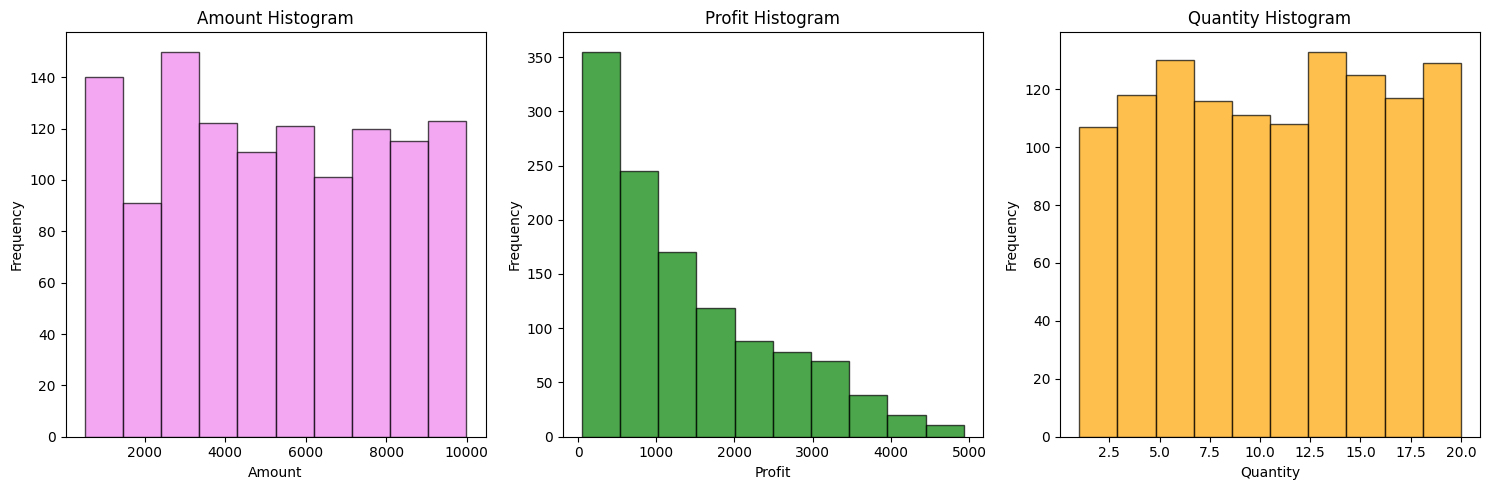

In [2]:
# Create histograms
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df.Amount.plot(kind="hist", bins=10, title='Amount Histogram', color='violet',edgecolor='black', alpha=0.7)
plt.xlabel('Amount')

plt.subplot(1, 3, 2)
df.Profit.plot(kind="hist", bins=10, title='Profit Histogram', color='green',edgecolor='black', alpha=0.7)
plt.xlabel('Profit')

plt.subplot(1, 3, 3)
df.Quantity.plot(kind="hist", bins=10, title='Quantity Histogram', color='orange',edgecolor='black', alpha=0.7)
plt.xlabel('Quantity')

plt.tight_layout()
plt.show()

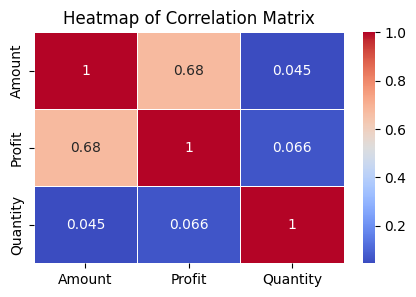

In [3]:
correlation_matrix = df[['Amount', 'Profit', 'Quantity']].corr()
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()


In [4]:
cols_to_drop = ['Order ID', 'CustomerName', 'City', 'Sub-Category', 'Order Date', 'Year-Month']
categorical_features = ['Category', 'PaymentMode', 'State']
numerical_features = ['Amount', 'Quantity']
target_variable = 'Profit'

print("\n--- Initial Cleaning & Preprocessing ---")
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print(f"Dropped identifier/high-cardinality/unused columns (incl. Sub-Category).")
print("Ensuring numerical features are numeric...")
for col in numerical_features + [target_variable]:
     df[col] = pd.to_numeric(df[col], errors='coerce')

# Selecting only columns needed for modeling
all_feature_cols = [col for col in numerical_features + categorical_features if col in df.columns]
cols_for_model = all_feature_cols + [target_variable]
df_model = df[cols_for_model].copy()
print(f"Selected columns for modeling: {cols_for_model}")

# One-Hot Encode Categorical Features
print("\n--- One-Hot Encoding Categorical Features ---")
categorical_features_in_df = [col for col in categorical_features if col in df_model.columns]
df_model = pd.get_dummies(df_model, columns=categorical_features_in_df, drop_first=True, dtype=float)
print(f"Applied one-hot encoding to: {categorical_features_in_df}")
print("Columns after encoding:")
final_feature_order = list(df_model.drop(columns=target_variable, errors='ignore').columns)
print(final_feature_order)

# Final NaN Drop & Feature/Target Definition
print("\n--- Defining Features (X) and Target (y) ---")
df_model.dropna(inplace=True)
print(f"Dropped rows with missing values. Final modeling shape: {df_model.shape}")

X = df_model.drop(columns=target_variable)
y = df_model[target_variable]

print(f"Final shape of features X: {X.shape}")
print(f"Final shape of target y: {y.shape}")


--- Initial Cleaning & Preprocessing ---
Dropped identifier/high-cardinality/unused columns (incl. Sub-Category).
Ensuring numerical features are numeric...
Selected columns for modeling: ['Amount', 'Quantity', 'Category', 'PaymentMode', 'State', 'Profit']

--- One-Hot Encoding Categorical Features ---
Applied one-hot encoding to: ['Category', 'PaymentMode', 'State']
Columns after encoding:
['Amount', 'Quantity', 'Category_Furniture', 'Category_Office Supplies', 'PaymentMode_Credit Card', 'PaymentMode_Debit Card', 'PaymentMode_EMI', 'PaymentMode_UPI', 'State_Florida', 'State_Illinois', 'State_New York', 'State_Ohio', 'State_Texas']

--- Defining Features (X) and Target (y) ---
Dropped rows with missing values. Final modeling shape: (1194, 14)
Final shape of features X: (1194, 13)
Final shape of target y: (1194,)


In [5]:
if 'X' in locals() and 'y' in locals() and not X.empty:

    print("\n---Splitting & Scaling ---")

    # Split Data into Training and Testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"\nPreprocessed data split into training and testing sets.")
    print(f"Training features shape: {X_train.shape}")
    print(f"Testing features shape:  {X_test.shape}")

    cols_to_scale = [col for col in numerical_features if col in X_train.columns]
    print(f"\nColumns identified for scaling: {cols_to_scale}")

    # Scale Numerical Features
    if cols_to_scale:
        scaler = StandardScaler()

        print("Fitting StandardScaler on training data numerical columns...")
        scaler.fit(X_train[cols_to_scale])

        print("Transforming numerical columns in training and testing data...")
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()

        X_train_scaled[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
        X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

        print("Scaling complete.")
        print("\nScaled Training Data Head (Numerical Columns):")
        print(X_train_scaled[cols_to_scale].head())

    else:
        print("\nNo numerical columns found to scale. Using unscaled data.")
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()


---Splitting & Scaling ---

Preprocessed data split into training and testing sets.
Training features shape: (955, 13)
Testing features shape:  (239, 13)

Columns identified for scaling: ['Amount', 'Quantity']
Fitting StandardScaler on training data numerical columns...
Transforming numerical columns in training and testing data...
Scaling complete.

Scaled Training Data Head (Numerical Columns):
       Amount  Quantity
728 -1.258524 -0.287390
138 -1.204471 -1.155376
582  1.580311 -1.502571
667 -0.548015 -1.502571
910  1.167092 -0.981779


In [6]:
# Model Training

print("\n--- Model Training ---")

# --- Model 1: Multiple Linear Regression ---
print("\nTraining Multiple Linear Regression...")
linear_model = LinearRegression()

# Train the model on the scaled training data
linear_model.fit(X_train_scaled, y_train)
print("Linear Regression training complete.")

# --- Model 2: Random Forest Regressor ---
print("\nTraining Random Forest Regressor...")
rf_model = RandomForestRegressor(n_estimators=100,
                                 random_state=42,
                                 n_jobs=-1,
                                 max_depth=10,
                                 min_samples_split=10)

# Train the model on the scaled training data
rf_model.fit(X_train_scaled, y_train)
print("Random Forest Regressor training complete.")



--- Model Training ---

Training Multiple Linear Regression...
Linear Regression training complete.

Training Random Forest Regressor...
Random Forest Regressor training complete.


In [7]:
    print("\n--- Model Evaluation ---")

    # Make predictions on the test set
    print("Making predictions on the test set...")
    y_pred_lr = linear_model.predict(X_test_scaled)
    y_pred_rf = rf_model.predict(X_test_scaled)
    print("Predictions complete.")

    # Evaluate Linear Regression
    print("\nEvaluating Linear Regression...")
    rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    r2_lr = r2_score(y_test, y_pred_lr)

    # Evaluate Random Forest
    print("Evaluating Random Forest Regressor...")
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    # Organize and Print Results
    print("\n--- Model Performance Metrics ---")
    print("\nLinear Regression:")
    print(f"  RMSE (Root Mean Squared Error): {rmse_lr:.4f}")
    print(f"  MAE (Mean Absolute Error):      {mae_lr:.4f}")
    print(f"  R² (R-squared):                 {r2_lr:.4f}")

    print("\nRandom Forest Regressor:")
    print(f"  RMSE (Root Mean Squared Error): {rmse_rf:.4f}")
    print(f"  MAE (Mean Absolute Error):      {mae_rf:.4f}")
    print(f"  R² (R-squared):                 {r2_rf:.4f}")

    # Create a comparison table
    results_df = pd.DataFrame({
        'Model': ['Linear Regression', 'Random Forest Regressor'],
        'RMSE': [rmse_lr, rmse_rf],
        'MAE': [mae_lr, mae_rf],
        'R-squared (R²)': [r2_lr, r2_rf]
    })
    # Set Model as index for better readability
    results_df.set_index('Model', inplace=True)

    print("\n--- Performance Comparison Table ---")
    print(results_df.round(4))


--- Model Evaluation ---
Making predictions on the test set...
Predictions complete.

Evaluating Linear Regression...
Evaluating Random Forest Regressor...

--- Model Performance Metrics ---

Linear Regression:
  RMSE (Root Mean Squared Error): 853.3150
  MAE (Mean Absolute Error):      657.4731
  R² (R-squared):                 0.4253

Random Forest Regressor:
  RMSE (Root Mean Squared Error): 787.2500
  MAE (Mean Absolute Error):      572.0816
  R² (R-squared):                 0.5109

--- Performance Comparison Table ---
                            RMSE       MAE  R-squared (R²)
Model                                                     
Linear Regression        853.315  657.4731          0.4253
Random Forest Regressor  787.250  572.0816          0.5109



--- Model Comparison Summary ---
Comparing the two models based on test set performance:
                            RMSE       MAE  R-squared (R²)
Model                                                     
Linear Regression        853.315  657.4731          0.4253
Random Forest Regressor  787.250  572.0816          0.5109

Conclusion: The Random Forest Regressor performed better.
- It achieved a lower RMSE (787.2500 vs 853.3150)
- It achieved a lower MAE (572.0816 vs 657.4731)
- It explained more variance in Profit (R² = 0.5109 vs 0.4253)

This suggests the Random Forest's ability to capture non-linear relationships was beneficial for this dataset.

Generating Actual vs. Predicted plot for Random Forest...


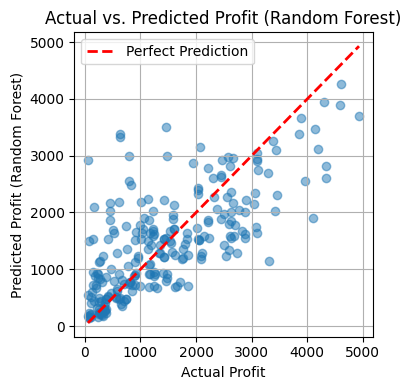


Generating Feature Importance plot for Random Forest...


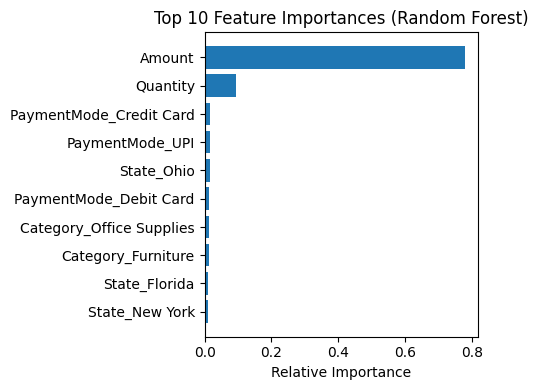

In [8]:


    # Model Comparison Summary
    print("\n--- Model Comparison Summary ---")
    print(f"Comparing the two models based on test set performance:")
    print(results_df.round(4))

    # Determine the better model based on R-squared
    better_model_name = results_df['R-squared (R²)'].idxmax()
    print(f"\nConclusion: The {better_model_name} performed better.")
    print(f"- It achieved a lower RMSE ({results_df.loc[better_model_name, 'RMSE']:.4f} vs {results_df.drop(better_model_name)['RMSE'].values[0]:.4f})")
    print(f"- It achieved a lower MAE ({results_df.loc[better_model_name, 'MAE']:.4f} vs {results_df.drop(better_model_name)['MAE'].values[0]:.4f})")
    print(f"- It explained more variance in Profit (R² = {results_df.loc[better_model_name, 'R-squared (R²)']:.4f} vs {results_df.drop(better_model_name)['R-squared (R²)'].values[0]:.4f})")
    print("\nThis suggests the Random Forest's ability to capture non-linear relationships was beneficial for this dataset.")


    # Visualization: Actual vs. Predicted Plot for Random Forest
    print("\nGenerating Actual vs. Predicted plot for Random Forest...")
    plt.figure(figsize=(4, 4))
    plt.scatter(y_test, y_pred_rf, alpha=0.5)
    # Add a line for perfect predictions (y_test = y_pred)
    min_val = min(y_test.min(), y_pred_rf.min())
    max_val = max(y_test.max(), y_pred_rf.max())
    plt.plot([min_val, max_val], [min_val, max_val], '--r', linewidth=2, label='Perfect Prediction')
    plt.xlabel("Actual Profit")
    plt.ylabel("Predicted Profit (Random Forest)")
    plt.title("Actual vs. Predicted Profit (Random Forest)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # Visualization: Feature Importance for Random Forest
    print("\nGenerating Feature Importance plot for Random Forest...")

    if 'final_feature_order' in locals() and final_feature_order:
        feature_names = final_feature_order
        importances = rf_model.feature_importances_
        indices = np.argsort(importances)[::-1]

        top_n = 10
        indices = indices[:top_n]

        plt.figure(figsize=(5, 4))
        plt.title(f"Top {top_n} Feature Importances (Random Forest)")
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    else:
         print("Could not generate feature importance plot: Feature names list ('final_feature_order') not found or empty.")


In [9]:
    print("\n--- Linear Regression Coefficients ---")

    intercept = linear_model.intercept_
    print(f"Intercept: {intercept:.4f}\n")

    coefficients = linear_model.coef_

    feature_names = X_train_scaled.columns

    coeff_df = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient'])

    coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
    coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

    print("Coefficients (sorted by absolute magnitude):")
    print(coeff_df[['Coefficient']].round(4))


--- Linear Regression Coefficients ---
Intercept: 968.3896

Coefficients (sorted by absolute magnitude):
                          Coefficient
Amount                       753.0556
PaymentMode_Credit Card      355.5338
PaymentMode_EMI              310.1842
PaymentMode_UPI              287.9379
PaymentMode_Debit Card       276.4309
State_Florida                205.5144
State_Ohio                  -127.4507
Category_Furniture           118.4019
Category_Office Supplies      88.8367
State_New York                86.8182
State_Texas                   69.6310
Quantity                      64.6067
State_Illinois               -61.9145
